In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump

In [4]:
# load insurance data
diabetes_df = pd.read_csv('diabetes_updated.csv')
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Diabetes EDA

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# get the summary statistics for the numerical columns
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# calculate the percentage of missing values per column
missing_data_rows = []
total_rows = len(diabetes_df)

for num in diabetes_df.columns:
    missing_values_count = diabetes_df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,Pregnancies,0,0%
1,Glucose,0,0%
2,BloodPressure,0,0%
3,SkinThickness,0,0%
4,Insulin,0,0%
5,BMI,0,0%
6,DiabetesPedigreeFunction,0,0%
7,Age,0,0%
8,Outcome,0,0%


Since there are no missing values in the datasets, there is no need for imputation.

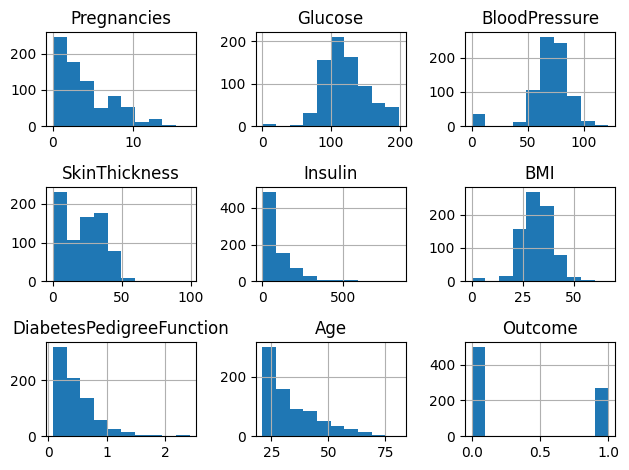

In [8]:
diabetes_df.hist()
plt.tight_layout()

"Glucose," "BloodPressure," and "BMI" follow Gaussian distributions, while the remaining variables exhibit non-Gaussian distributions.

<Axes: >

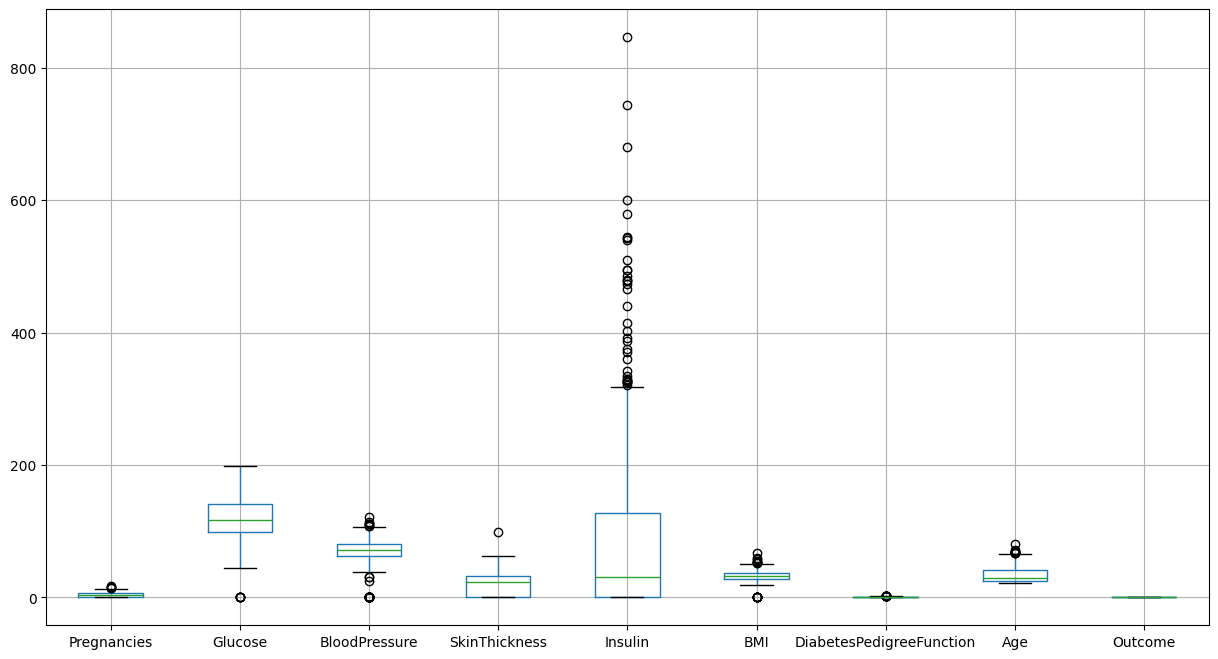

In [9]:
# plot the distribution of numerical features along with outliers
diabetes_df.boxplot(figsize=(15, 8))

All variables display outliers, which will be addressed using the Winsorization technique in the following section.

## Feature engineering

In [10]:
# position the charges column in the first column index
first_column = diabetes_df['Outcome']

# drop this column from its current position
diabetes_df.drop(columns=['Outcome'], inplace=True)

# Insert the column at the desired position (index 0)
diabetes_df.insert(0, 'Outcome', first_column)

# Display the modified DataFrame
diabetes_df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33


In [117]:
# Define independent features (X) and dependent feature (y)
X = diabetes_df.drop(columns=['Outcome'])  # Independent features
y = diabetes_df['Outcome']  # Dependent feature

<Axes: >

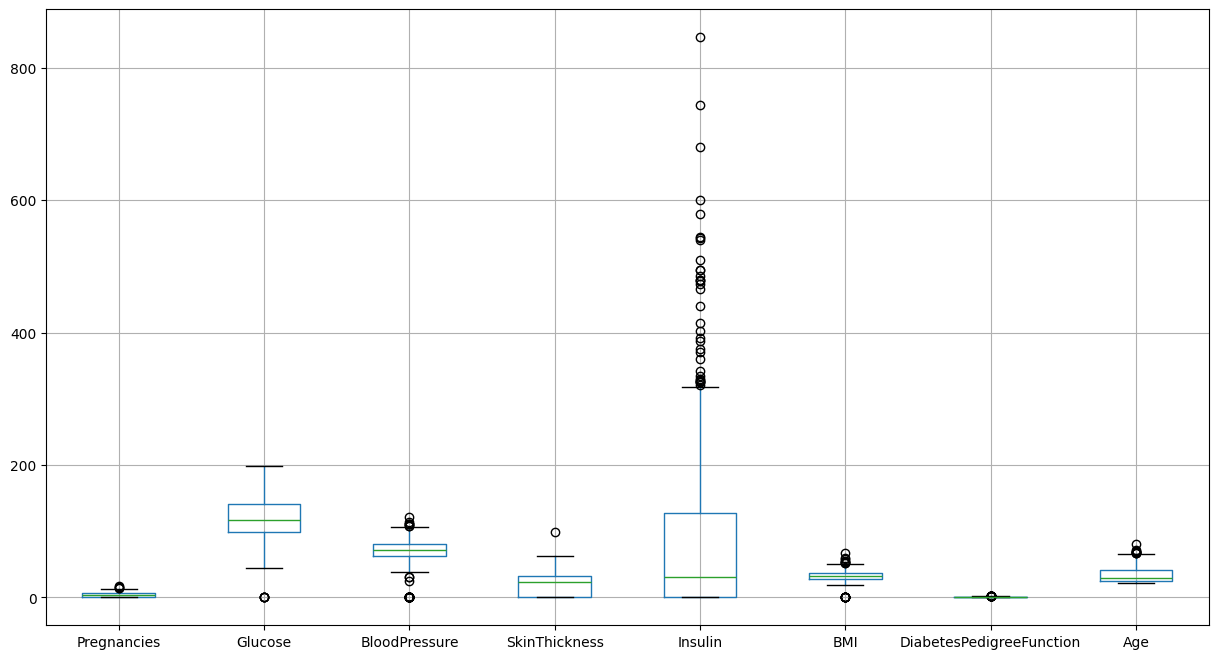

In [118]:
# plot the distribution of features
X.boxplot(figsize=(15, 8))

<Axes: >

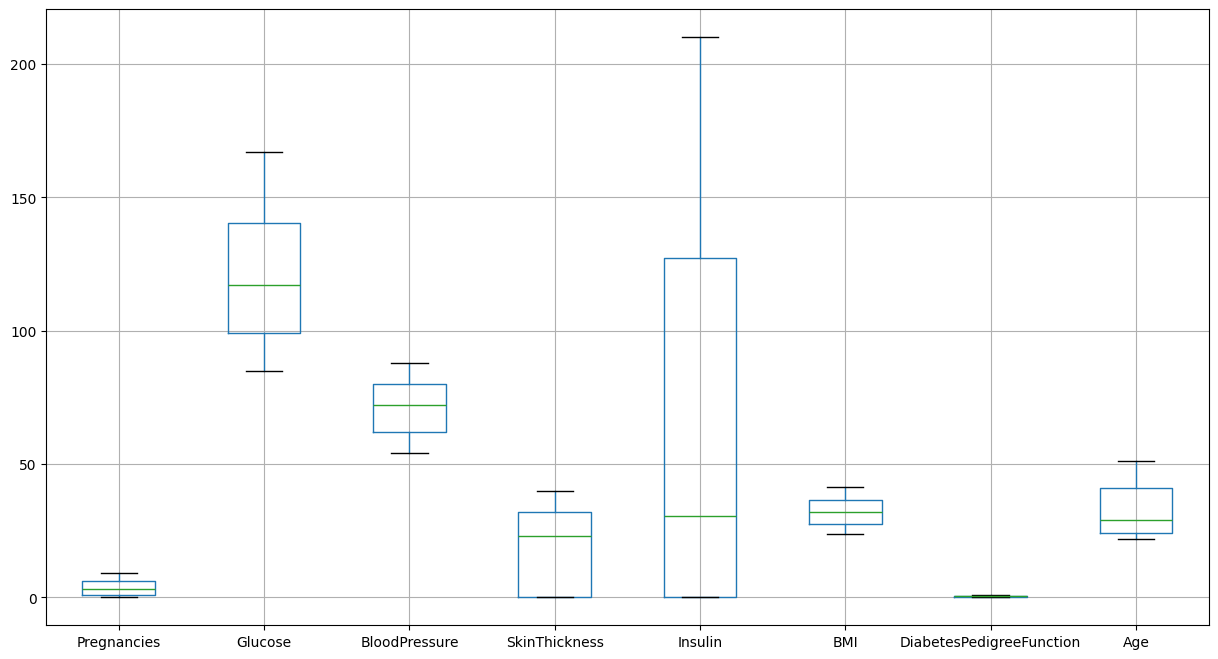

In [119]:
# Apply winsorization to each column and plot the effect of it on them
for column in X:
    X[column] = mstats.winsorize(X[column], limits=(0.10, 0.10))
X.boxplot(figsize=(15, 8))

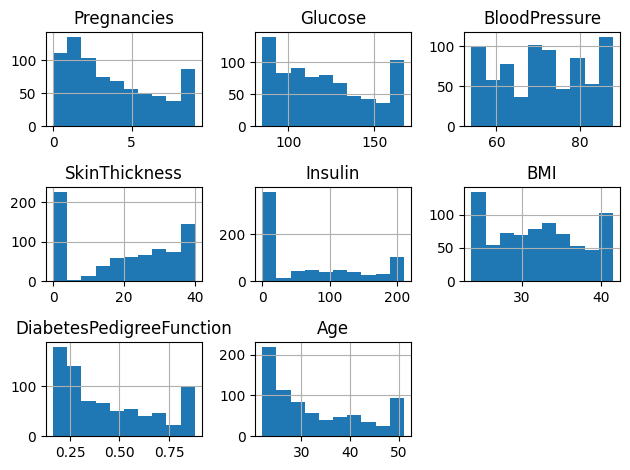

In [120]:
# plot the distribution of the X features after winsorization
X.hist()
plt.tight_layout()

After implementing Winsorization, the distributions of the features have been altered, making MinMaxScaler() more appropriate since no feature follows a Gaussian distribution suitable for StandardScaler(). Therefore, I forgo StandardScaler() and exclusively apply MinMaxScaler() to all features.

In [121]:
# use MinMaxScaler to normalise the X features
scaler = MinMaxScaler()

# fit the scaler to the data and transform the data
X_scaled = scaler.fit_transform(X)

# convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# display the scaled DataFrame
X_scaled_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.666667,0.768293,0.529412,0.875,0.000000,0.558659,0.646154,0.965517
1,0.111111,0.000000,0.352941,0.725,0.000000,0.167598,0.260140,0.310345
2,0.888889,1.000000,0.294118,0.000,0.000000,0.000000,0.709091,0.344828
3,0.111111,0.048780,0.352941,0.575,0.447619,0.251397,0.002797,0.000000
4,0.000000,0.634146,0.000000,0.875,0.800000,1.000000,1.000000,0.379310


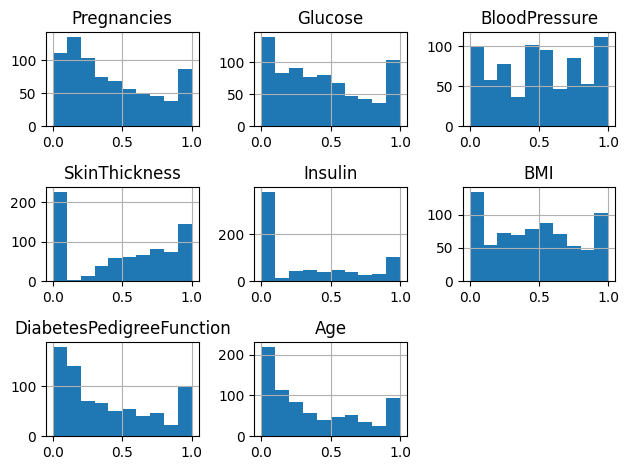

In [122]:
# plot the distributions of the X features after scaling
X_scaled_df.hist()
plt.tight_layout()

In [123]:
# concatenate the scaled features with the target variable
scaled_data_with_target = pd.concat([y,X_scaled_df], axis=1)

# display the scaled DataFrame
scaled_data_with_target.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,0.666667,0.768293,0.529412,0.875,0.000000,0.558659,0.646154,0.965517
1,0,0.111111,0.000000,0.352941,0.725,0.000000,0.167598,0.260140,0.310345
2,1,0.888889,1.000000,0.294118,0.000,0.000000,0.000000,0.709091,0.344828
3,0,0.111111,0.048780,0.352941,0.575,0.447619,0.251397,0.002797,0.000000
4,1,0.000000,0.634146,0.000000,0.875,0.800000,1.000000,1.000000,0.379310


### Correlation between independant variables and the dependant variable "Outcome"

In [124]:
corr_matrix = scaled_data_with_target.corr()
corr_matrix

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,1.000000,0.221354,0.489278,0.144407,0.063409,0.111454,0.307023,0.179224,0.283338
Pregnancies,0.221354,1.000000,0.148621,0.205626,-0.090756,-0.099295,0.010978,-0.019340,0.612931
Glucose,0.489278,0.148621,1.000000,0.233346,0.043627,0.276016,0.235980,0.098753,0.286831
BloodPressure,0.144407,0.205626,0.233346,1.000000,0.108254,0.015427,0.291589,0.034059,0.351382
SkinThickness,0.063409,-0.090756,0.043627,0.108254,1.000000,0.534161,0.389953,0.171444,-0.113867
Insulin,0.111454,-0.099295,0.276016,0.015427,0.534161,1.000000,0.212141,0.217590,-0.075650
BMI,0.307023,0.010978,0.235980,0.291589,0.389953,0.212141,1.000000,0.139373,0.079984
DiabetesPedigreeFunction,0.179224,-0.019340,0.098753,0.034059,0.171444,0.217590,0.139373,1.000000,0.044148
Age,0.283338,0.612931,0.286831,0.351382,-0.113867,-0.075650,0.079984,0.044148,1.000000


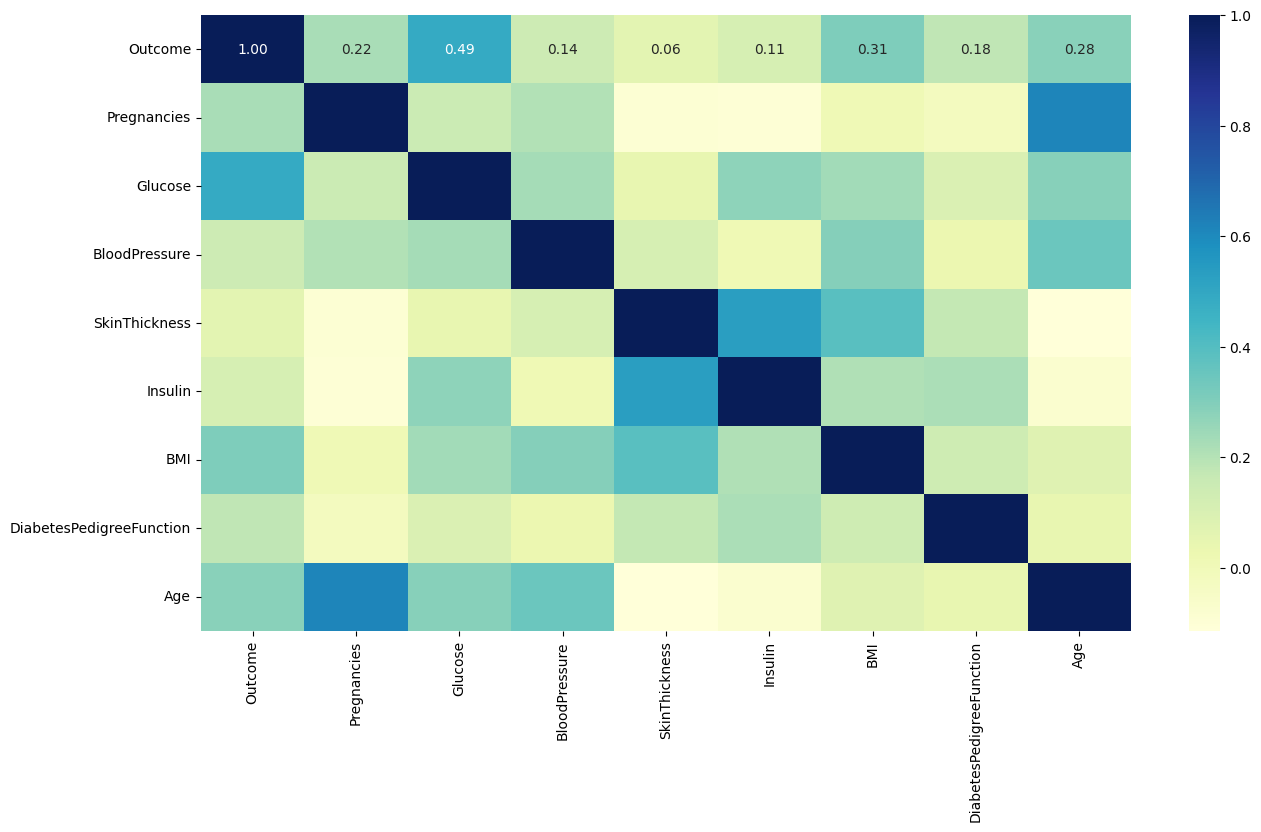

In [125]:
plt.figure(figsize=(15, 8))  # adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

Of all the features, "Glucose," "BMI," and "Age" demonstrate the strongest correlations with "Outcome."

## Split dataset into train & test sets

In [126]:
# Define independent features (X) and dependent feature (y)
X = diabetes_df.drop(columns=['Outcome'])  # Independent features
y = diabetes_df['Outcome']  # Dependent feature

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
# winsorize the train and test sets separately to avoid bias
for column in X_train:
    X_train[column] = mstats.winsorize(X_train[column], limits=(0.10, 0.10))

for column in X_test:
    X_test[column] = mstats.winsorize(X_test[column], limits=(0.10, 0.10))

In [128]:
# Fit the scaler on train data
scaler = MinMaxScaler()
scaler.fit(X_train)

# Apply the scaler on train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Build and fit a multivariate linear regression model

In [129]:
# initiate an empty model
multivariate_reg_model = LinearRegression()

# define a parameter grid for model optimisation
param_grid = {
			'fit_intercept': [True, False],
			'positive': [True, False]
			}
# instantiate GridSearchCV
grid_search = GridSearchCV(multivariate_reg_model, param_grid, cv=5)

# fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# get the best model from the grid search
best_model = grid_search.best_estimator_

# fit the best model to the training data
best_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = best_model.predict(X_test)

In [130]:
# intercept & coefficients of the trained insurance model 
print('Intercept: \n', best_model.intercept_)
print('Coefficients: \n', best_model.coef_)
print('Score: \n', best_model.score(X_test, y_test))

Intercept: 
 -0.14800194465726646
Coefficients: 
 [ 0.04372273  0.5946068  -0.151543    0.01870223 -0.10121541  0.35390992
  0.15548949  0.27611618]
Score: 
 0.21947800514567362


**Intercept:**

The intercept (β0) represents the value of the dependent variable when all independent variables are zero. In this case, the intercept is approximately -0.148. It suggests that when all other independent variables are zero, the predicted value of the diabetes progression is -0.148.

**Coefficients:**

The coefficients (β1,β2,...,βn) represent the change in the dependent variable for a one-unit change in the corresponding independent variable, holding all other variables constant.
For example, a coefficient of 0.0437 for the first independent variable "Pregnancies" suggests that for every one-unit increase in "Pregnancies", the predicted value of the diabetes progression increases by approximately 0.0437, holding all other variables constant.
Similarly, a coefficient of 0.5946 for the second independent variable suggests that for every one-unit increase in the second independent variable "Glucose", the predicted value of the diabetes progression increases by approximately 0.5946, holding all other variables constant.
Negative coefficients indicate that an increase in the corresponding independent variable is associated with a decrease in the predicted value of the diabetes progression.

**Score (R-squared):**

The score, or coefficient of determination R-squared, measures the proportion of the variance in the diabetes progression that is predictable from the independent variables.
A score of 0.2195 means that approximately 21.95% of the variance in the diabetes progression can be explained by the independent variables included in the model.

In other words, the model accounts for about 21.95% of the variability observed in the diabetes progression. This value indicates the proportion of the total variation in the diabetes progression that is explained by the variation in the independent variables.

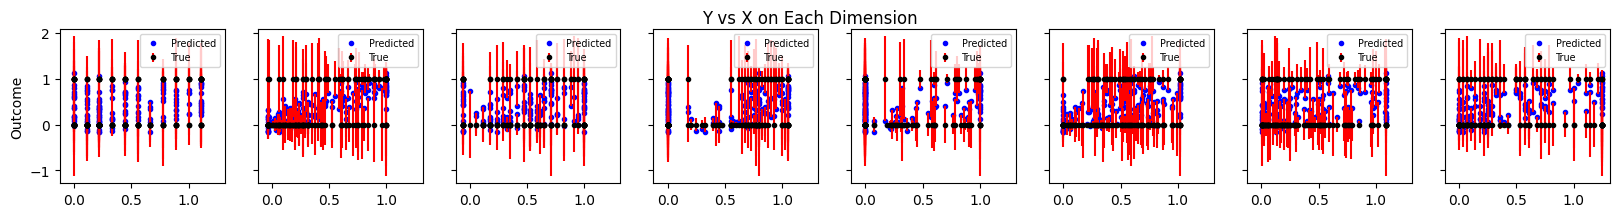

In [131]:
## Plot the errors
fig, ax = plt.subplots(1, X_test.shape[1], sharey=True, sharex=True, figsize=(20,2))
fig.suptitle("Y vs X on Each Dimension")
ax[0].set_ylabel(diabetes_df.columns[0])

# Get values for the error bar
residuals = y_test - y_pred
error_bar_values = np.abs(residuals)

# # Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(X_test[:, i], np.array(y_test), yerr=error_bar_values, fmt='.k', ecolor='red', label='True')
    ax[i].scatter(X_test[:,i], np.array(y_pred), c='b', marker='.', label='Predicted')
    ax[i].legend(loc='best', fontsize='x-small')

In [115]:
# evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test, y_pred)

# print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2_square}")

Mean Squared Error: 0.17920147841043205
R-squared: 0.21947800514567362


**Mean Squared Error (MSE):** The mean squared error measures the average of the squares of the errors between the actual values (y_test) and the predicted values (y_pred). In this case, the MSE of approximately 0.1792 means that, on average, the squared difference between the actual diabetes progression and the predicted diabetes progression is around 0.1792. Since the MSE is a squared metric, its value is sensitive to large errors, and a lower MSE indicates better model performance.

In [46]:
# save the model
dump(best_model, 'diabetes_multivariate_reg_model.joblib')

['diabetes_multivariate_reg_model.joblib']

**NOTE:** To run the model, access and run **predict_diabetes.ipynb** in the same directory.